In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" director
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
#from tqdm import tqdm 
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

In [3]:
tr_csv_dr= '../input/planets-dataset/planet/planet/train_classes.csv'
t_csv_dr = '../input/planets-dataset/planet/planet/sample_submission.csv'
tr_img_dr = '../input/planets-dataset/planet/planet/train-jpg/'
t_img_dr= '../input/planets-dataset/planet/planet/test-jpg/'

In [4]:
tr_df=pd.read_csv(tr_csv_dr)
t_df=pd.read_csv(t_csv_dr)
tr_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


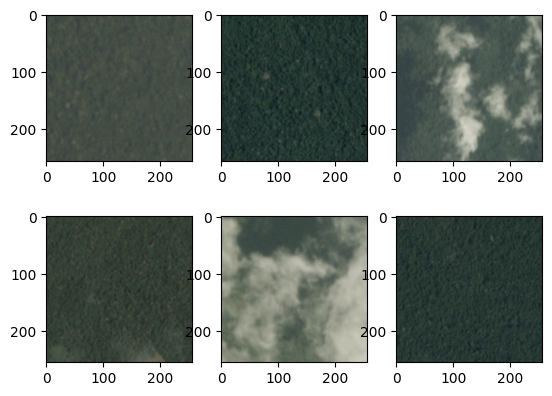

In [5]:
fd=t_img_dr
for i in range (6):
    plt.subplot(230+1+i)
    #plt.subplot(230 + 1 + i)
    filename = f"{fd}test_{i}.jpg"
    plt.imshow(imread(filename))
plt.show()

In [6]:
tag_s=tr_df['tags'].apply(lambda x: x.split())
ta_gs=pd.Series([i for j in tag_s for i in j ])
count_tag=ta_gs.value_counts()
count_tag

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
Name: count, dtype: int64

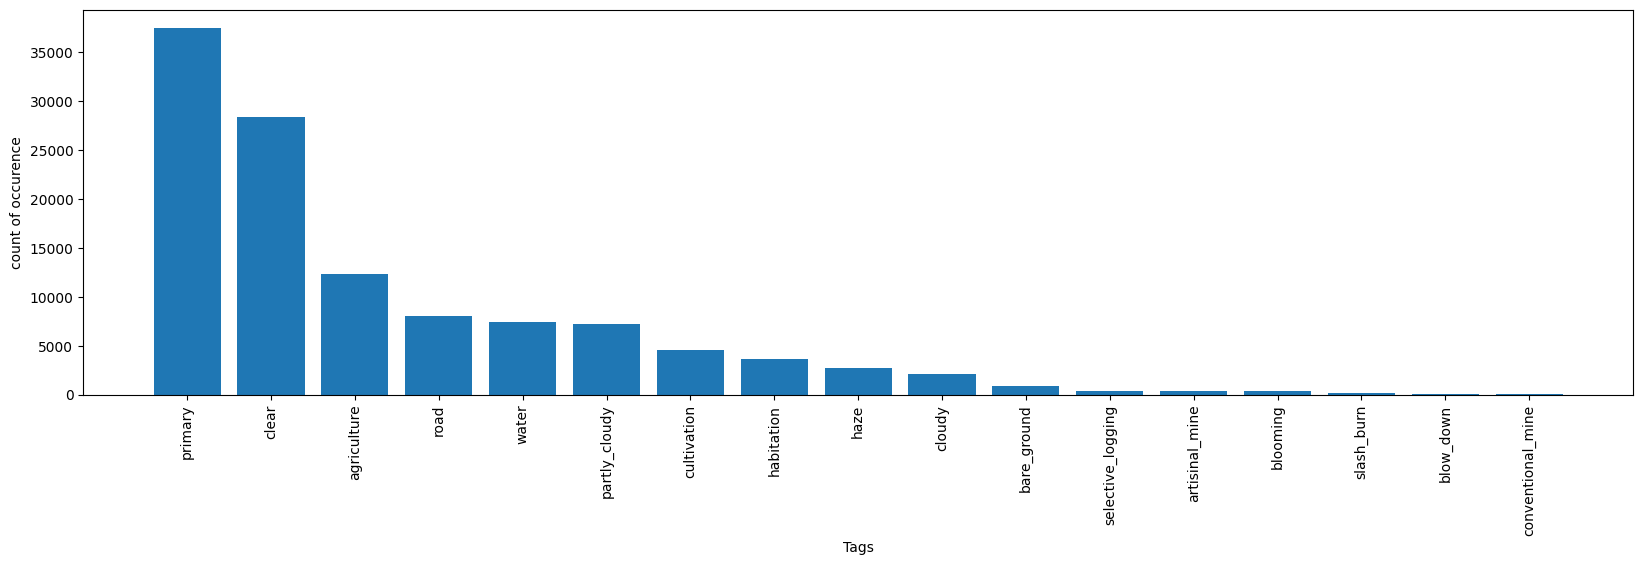

In [7]:
plt.figure(figsize=(20,5))
plt.bar(count_tag.index,count_tag.values)
plt.ylabel('count of occurence')
plt.xlabel('Tags')
plt.xticks(rotation=90)
plt.show();

In [8]:
tr_dt=tr_df.copy()
for i in count_tag.index:
    tr_dt[i]=tr_df['tags'].apply(lambda j : 1 if i in j.split() else 0)

t_dt=t_df.copy()
for i in count_tag.index:
    t_dt[i]=t_df['tags'].apply(lambda j : 1 if i in j.split() else 0)
tr_dt.head()

,image_name,tags,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down,conventional_mine
0,train_0,haze primary,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [9]:
tr_dt1=tr_dt.copy()
tr_dt1['image_name']=tr_dt1['image_name'].apply(lambda i: '{}.jpg'.format(i))
tr_dt1.head()

,image_name,tags,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down,conventional_mine
0,train_0.jpg,haze primary,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [10]:
from tqdm import tqdm
x_train = []
for f, tags in tqdm(tr_df.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    x_train.append(cv2.resize(img, (64, 64)))  # Indicate the IMG Size
    
x_tr = np.array(x_train, np.float32) / 255.


100%|██████████| 40479/40479 [05:59<00:00, 112.45it/s]


In [11]:
x_x = []


for image_name, tags in tqdm(t_df[0 : 40669].values, miniters=1000):
    
    arr = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(image_name))
   
    x_x.append(cv2.resize(arr, (64, 64)))


for image_name, tags in tqdm(t_df[40669:].values, miniters=1000):
    
    arr = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image_name))
    
    x_x.append(cv2.resize(arr, (64, 64)))
    
x_tet = np.array(x_x, np.float32) / 255.

100%|██████████| 20522/20522 [03:09<00:00, 108.07it/s]


In [12]:
y_train= tr_dt.drop(columns=['image_name','tags']).values
y_tes=t_dt.drop(columns=['image_name','tags']).values
from sklearn.model_selection import train_test_split
tts=train_test_split
xtrr,xtt,ytr,yt=tts(x_tr,y_train,random_state=1,test_size=0.1)

In [13]:
import gc
gc.collect()
dm=np.prod((np.array(xtrr).shape)[1:])
no_l=17


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.metrics import fbeta_score
from tensorflow.keras import backend as K


def f2_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float')
    y_pred = K.cast(K.round(y_pred), 'float')
    
    # Calculate precision, recall, and F2 score
    tp = K.sum(K.clip(y_true * y_pred, 0, 1))
    fp = K.sum(K.clip(y_pred - y_true, 0, 1))
    fn = K.sum(K.clip(y_true - y_pred, 0, 1))
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    beta = 2
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + K.epsilon())
    
    return f2_score



In [15]:
model1 = keras.Sequential()

# Adding The Layers
# Batch Normalization layer is added as the first layer of the model, which normalize the input data.
model1.add(BatchNormalization(input_shape=(64, 64, 3)))

# Convolutional layers and MaxPooling layers are added to extract features from the input images and reduce the spatial dimensions of the feature maps respectively.
model1.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layers are added to prevent overfitting.
model1.add(Dropout(0.2))

# Same set of layers are added for the next set of features
model1.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

# Flatten layer is added to convert the 2D feature maps into a 1D feature vector
model1.add(Flatten())

# Fully connected layers (dense layers) and dropout layers are added
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(17, activation='sigmoid'))
opt = Adam(lr=1e-4)
    
    # We need binary here, since categorical_crossentropy l1 norms the output before calculating loss.
model1.compile(loss='binary_crossentropy',optimizer=opt,metrics=[f2_score,'accuracy'])


# Compiling the model by specifying the loss function, optimizer, and evaluation metrics
#model1.compile(optimizer=optimizer_Adam,loss='binary_crossentropy',metrics=[f2_score,'accuracy'])


In [16]:
mod_history=model1.fit(xtrr,ytr,validation_data=(xtt,yt), epochs=1,batch_size=20)


1822/1822 [==============================] - 297s 162ms/step - loss: 0.1840 - f2_score: 0.7228 - accuracy: 0.8819 - val_loss: 0.1476 - val_f2_score: 0.7604 - val_accuracy: 0.9261


In [17]:
pred=model1.predict(x_tet)

1913/1913 [==============================] - 106s 55ms/step


In [18]:
p_df=pd.DataFrame(pred,columns=count_tag.index)

In [19]:
sb=pd.read_csv(t_csv_dr)
sb.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [20]:
preds = []
# Loop through the sample submission DataFrame
for i in tqdm(range(p_df.shape[0]), miniters=1000):
    # Get the i-th row of the DataFrame
    a = p_df.loc[[i]]
    # Apply a lambda function to get a Boolean array indicating which columns have values greater than 0.2
    a = a.apply(lambda x: x > 0.2, axis=1)
    # Transpose the DataFrame
    a = a.transpose()
    # Get the rows where the Boolean array is True
    a= a.loc[a[i] == True]
    # Join the index of the DataFrame (which contains the tags) into a single string
    ' '.join(list(a.index))
    # Append the string of tags to the preds list
    preds.append(' '.join(list(a.index)))

# Assign the preds list as the 'tags' column of the sample submission DataFrame
sb['tags'] = preds

# Save the sample submission DataFrame to a CSV file
#df_samplesub.to_csv('CMT_submission.csv', index=False)

100%|██████████| 61191/61191 [01:20<00:00, 763.11it/s]


In [21]:
sb.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy


In [22]:
sb.to_csv('CMT_submission.csv', index=False)